# **E-commerce Customer Behavior Analysis** 

**Team Members:**
- Norhan Mohamed Swar, 231000486
- Nagwa Saad Abo shabaan, 231002541
- Salma Hisham Mohamed, 231000533

___

# `00` Import Dependencies

In [322]:
# Install Dependencies
# pip install yellowbrick pyspark


In [304]:
# For Manipulation
import pandas as pd
import numpy as np
# For Visualization
import matplotlib.pyplot as plt
import seaborn as sns
# For pyspark usage
from pyspark.sql import SparkSession
import pyspark.sql.functions as fn
from pyspark.sql.functions import when
from pyspark.sql.functions import col
from pyspark.ml.feature import StringIndexer, OneHotEncoder, StandardScaler
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.classification import LogisticRegression
from pyspark.ml import Pipeline
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from pyspark.mllib.evaluation import MulticlassMetrics
from pyspark.ml.feature import StandardScaler, StandardScalerModel
from pyspark.ml.clustering import KMeans
from yellowbrick.cluster import KElbowVisualizer
from pyspark.ml.evaluation import ClusteringEvaluator

# `01` Initialize Spark Session and Read Data

In [305]:
# Initializing Spark Session
spark = SparkSession.builder.appName("CustomerSegmentation").getOrCreate()

In [306]:
# Loading The Dataset
customer_data = spark.read.csv("E-commerce Customer Behavior.csv", header=True, inferSchema=True)
customer_data.show(10)


+-----------+------+---+-------------+---------------+-----------+---------------+--------------+----------------+------------------------+------------------+
|Customer ID|Gender|Age|         City|Membership Type|Total Spend|Items Purchased|Average Rating|Discount Applied|Days Since Last Purchase|Satisfaction Level|
+-----------+------+---+-------------+---------------+-----------+---------------+--------------+----------------+------------------------+------------------+
|        101|Female| 29|     New York|           Gold|     1120.2|             14|           4.6|            true|                      25|         Satisfied|
|        102|  Male| 34|  Los Angeles|         Silver|      780.5|             11|           4.1|           false|                      18|           Neutral|
|        103|Female| 43|      Chicago|         Bronze|     510.75|              9|           3.4|            true|                      42|       Unsatisfied|
|        104|  Male| 30|San Francisco|        

# `02` Basic EDA

In [307]:
customer_data.printSchema()

root
 |-- Customer ID: integer (nullable = true)
 |-- Gender: string (nullable = true)
 |-- Age: integer (nullable = true)
 |-- City: string (nullable = true)
 |-- Membership Type: string (nullable = true)
 |-- Total Spend: double (nullable = true)
 |-- Items Purchased: integer (nullable = true)
 |-- Average Rating: double (nullable = true)
 |-- Discount Applied: boolean (nullable = true)
 |-- Days Since Last Purchase: integer (nullable = true)
 |-- Satisfaction Level: string (nullable = true)



In [308]:
customer_df = customer_data.toPandas()
customer_df.describe(include= 'all').T

,count,unique,top,freq,mean,std,min,25%,50%,75%,max
Customer ID,350.0,NaN,NaN,NaN,275.5,101.180532,101.0,188.25,275.5,362.75,450.0
Gender,350,2,Female,175,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Age,350.0,NaN,NaN,NaN,33.597143,4.870882,26.0,30.0,32.5,37.0,43.0
City,350,6,New York,59,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Membership Type,350,3,Gold,117,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Total Spend,350.0,NaN,NaN,NaN,845.381714,362.058695,410.8,502.0,775.2,1160.6,1520.1
Items Purchased,350.0,NaN,NaN,NaN,12.6,4.155984,7.0,9.0,12.0,15.0,21.0
Average Rating,350.0,NaN,NaN,NaN,4.019143,0.580539,3.0,3.5,4.1,4.5,4.9
Discount Applied,350,2,True,175,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Days Since Last Purchase,350.0,NaN,NaN,NaN,26.588571,13.440813,9.0,15.0,23.0,38.0,63.0


In [309]:
customer_df.isnull().sum()

Customer ID                 0
Gender                      0
Age                         0
City                        0
Membership Type             0
Total Spend                 0
Items Purchased             0
Average Rating              0
Discount Applied            0
Days Since Last Purchase    0
Satisfaction Level          2
dtype: int64


### Explore Categorical columns


In [310]:
customer_data.select(['Gender']).distinct().show()

+------+
|Gender|
+------+
|Female|
|  Male|
+------+



In [311]:
customer_data.select(['City']).distinct().show()


+-------------+
|         City|
+-------------+
|  Los Angeles|
|San Francisco|
|      Chicago|
|      Houston|
|        Miami|
|     New York|
+-------------+



In [312]:
customer_data.select(['Membership Type']).distinct().show()

+---------------+
|Membership Type|
+---------------+
|         Silver|
|           Gold|
|         Bronze|
+---------------+



In [313]:
customer_data.select(['Satisfaction Level']).distinct().show()

+------------------+
|Satisfaction Level|
+------------------+
|       Unsatisfied|
|         Satisfied|
|           Neutral|
|              NULL|
+------------------+



# `03` Comprehensive E-Commerce Customer Behavior Analysis

## Q1 : Can we segment customers based on their demographic information (Age, Gender, City) and shopping behaviors (Total Spend, Number of Items Purchased, Membership Type)

### **Customer Segmentation based on 'Membership', 'Age', 'City', and 'Item Purchased':**


In [314]:
# Create age groups
customer_df_age_groups = customer_data.withColumn("Age Group",
                       when(customer_data["Age"] < 35, "Under 35")
                       .when((customer_data["Age"] >= 35) & (customer_data["Age"] <= 50), "Between 35-50")
                       .otherwise("Over 50"))

# Group by Membership Type, Age Group, and City
customer_segments = customer_df_age_groups.groupBy("Membership Type", "Age Group", "City").agg({
    "Total Spend": "mean",
    "Items Purchased": "sum"
})

# Group by City separately
city_segments = customer_df_age_groups.groupBy("City").agg({
    "Total Spend": "mean",
    "Items Purchased": "sum"
})

# Show all segments in a single DataFrame
print('Customer Segmentation Result :  ')
customer_segments.show()

Customer Segmentation Result :  
+---------------+-------------+-------------+--------------------+------------------+
|Membership Type|    Age Group|         City|sum(Items Purchased)|  avg(Total Spend)|
+---------------+-------------+-------------+--------------------+------------------+
|         Silver|Between 35-50|  Los Angeles|                 288|            814.65|
|         Bronze|Between 35-50|      Chicago|                 546| 499.8827586206897|
|           Gold|     Under 35|     New York|                 901|1165.0355932203393|
|         Silver|     Under 35|  Los Angeles|                 401| 799.2114285714289|
|         Bronze|Between 35-50|      Houston|                 439|446.89482758620665|
|         Silver|     Under 35|        Miami|                 675| 690.3896551724141|
|           Gold|     Under 35|San Francisco|                1141|1460.4561403508774|
|           Gold|Between 35-50|San Francisco|                  19|            1420.8|
+---------------+----

### **Customer Segmentation based on 'City', and 'Item Purchased':**


In [315]:
# Show city segments separately
city_segments.show()

+-------------+--------------------+------------------+
|         City|sum(Items Purchased)|  avg(Total Spend)|
+-------------+--------------------+------------------+
|  Los Angeles|                 689| 805.4915254237288|
|San Francisco|                1160|1459.7724137931039|
|      Chicago|                 546| 499.8827586206897|
|      Houston|                 439|446.89482758620665|
|        Miami|                 675| 690.3896551724141|
|     New York|                 901|1165.0355932203393|
+-------------+--------------------+------------------+



### **Customer Segmentation based on 'Membership', 'City', and 'Item Purchased':**


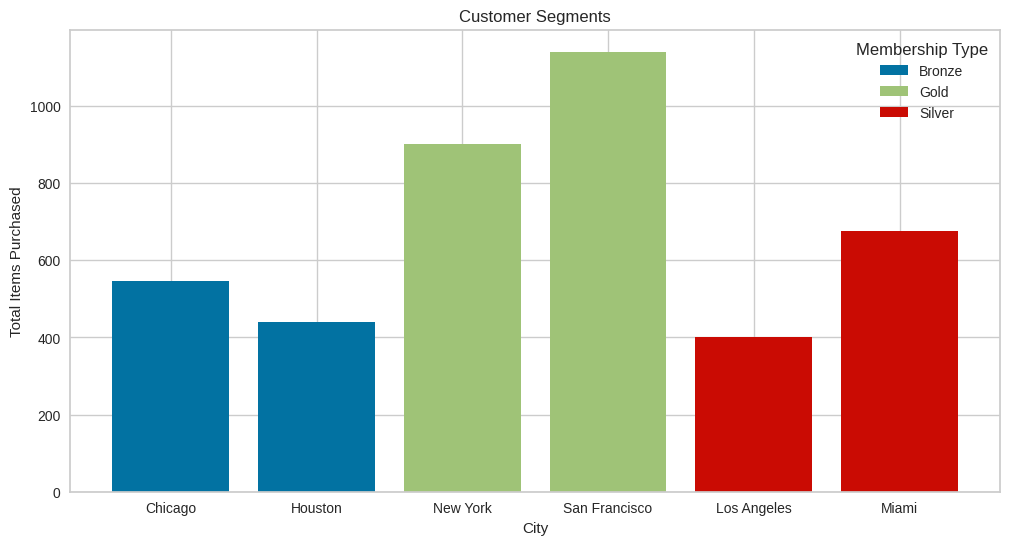

In [316]:
# Convert Spark DataFrame to Pandas DataFrame
customer_segments_pd = customer_segments.toPandas()

# Plot Customer Segments
plt.figure(figsize=(12, 6))
for membership_type, group in customer_segments_pd.groupby('Membership Type'):
    plt.bar(group['City'] , group['sum(Items Purchased)'], label=membership_type)
customer_df
plt.title('Customer Segments')
plt.xlabel('City')
plt.ylabel('Total Items Purchased')
plt.legend(title='Membership Type')
plt.show()

## **Customer Segmentation Analysis based on 'Membership', 'Age', 'City', and 'Item Purchased':**

#### ○ Gold Members (Under 35 in New York):

      • Exhibit the highest average total spending (1165.04) and a substantial sum of items purchased (901) and Indication a potentially 
       high-value and loyal customer segment.

#### ○ Silver Members (Under 35 in Los Angeles):

      • Show a considerable sum of items purchased (401) and a moderate average total spending (799.21).
      
#### ○ Bronze Members (Between 35-50 in Chicago):

      • Have a high sum of items purchased (546) but a relatively lower average total spending (499.88).
		


### Customer Segmentation based on their 'Membership Type', 'Total Spend', and 'Items Purchased' **Using Kmeans**. 

In [317]:
# split the columns we want to analyze
customer_seg_data = customer_data['Membership Type', 'Total Spend', 'Items Purchased']
customer_seg_data.show(3)

# # Encoding 'Membership Type'
customer_seg = customer_seg_data.replace(['Bronze', 'Silver', 'Gold'], ['0', '1', '2'], 'Membership Type')
customer_seg = customer_seg.withColumn("Membership Type", customer_seg['Membership Type'].cast('integer'))

# Assemble features into a single vector
assembler = VectorAssembler(inputCols=['Membership Type Index', 'Total Spend', 'Items Purchased'],
                            outputCol="features")
customer_seg = assembler.transform(customer_seg_encoded)
customer_seg.show(3)

# Standardize features
scaler = StandardScaler(inputCol="features", outputCol="scaled_features")
scaler_model = scaler.fit(customer_seg)
scaled_customer_seg = scaler_model.transform(customer_seg)
scaled_customer_seg.show(3)

+---------------+-----------+---------------+
|Membership Type|Total Spend|Items Purchased|
+---------------+-----------+---------------+
|           Gold|     1120.2|             14|
|         Silver|      780.5|             11|
|         Bronze|     510.75|              9|
+---------------+-----------+---------------+
only showing top 3 rows

+---------------+-----------+---------------+---------------------+-----------------+
|Membership Type|Total Spend|Items Purchased|Membership Type Index|         features|
+---------------+-----------+---------------+---------------------+-----------------+
|           Gold|     1120.2|             14|                  0.0|[0.0,1120.2,14.0]|
|         Silver|      780.5|             11|                  1.0| [1.0,780.5,11.0]|
|         Bronze|     510.75|              9|                  2.0| [2.0,510.75,9.0]|
+---------------+-----------+---------------+---------------------+-----------------+
only showing top 3 rows

+---------------+---------

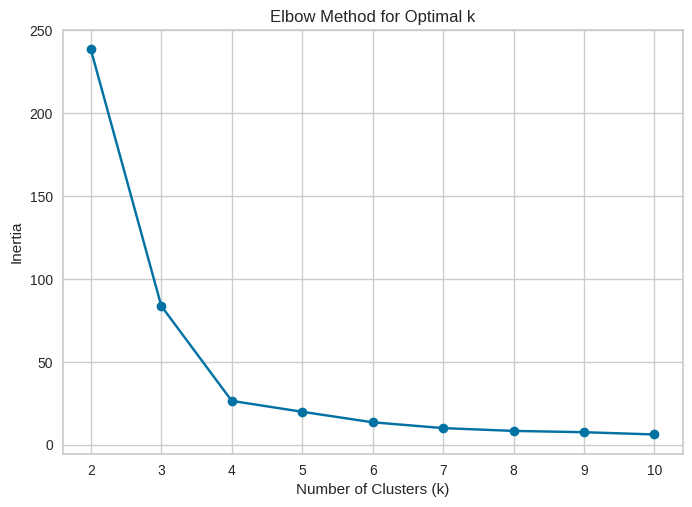

In [318]:
## Find the Best k splits for kmeans
# Calculate inertia for different values of k
inertia = []
for k in range(2, 11):
    kmeans = KMeans(k=k)
    kmeans.setFeaturesCol("scaled_features")
    model = kmeans.fit(scaled_customer_seg)
    inertia.append(model.summary.trainingCost)

# Plot the inertia values
plt.plot(range(2, 11), inertia, marker='o')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Inertia')
plt.title('Elbow Method for Optimal k')
plt.show()

In [319]:

# Train KMeans model
kmeans = KMeans(featuresCol="scaled_features", k= 4, seed=42)  # I have tried 3 and 4, 4 is way higher in Silhouette score
# Make predictions
predictions = kmeans.fit(scaled_customer_seg).transform(scaled_customer_seg)

# Evaluate clustering performance
silhouette =  ClusteringEvaluator().evaluate(predictions)
print(f"Silhouette score: {silhouette}")

Silhouette score: 0.9409567254207089


In [320]:
cluster_distribution = predictions.select("prediction").toPandas()

# Count the occurrences of each cluster label and Rename clusters
cluster_distribution_counts = cluster_distribution["prediction"].value_counts().sort_index()
cluster_distribution_counts

prediction
0    117
1    116
2     59
3     58
Name: count, dtype: int64

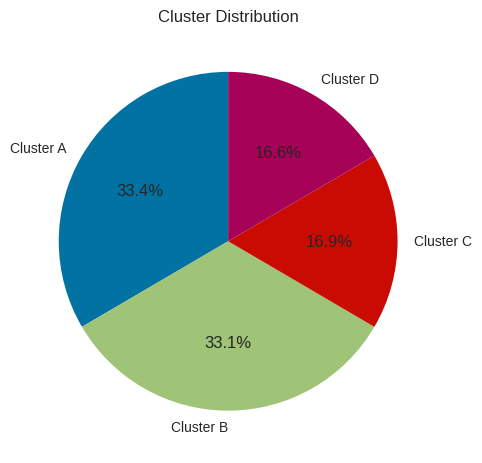


Cluster 0 Sample:

+---------------+-----------+---------------+
|Membership Type|Total Spend|Items Purchased|
+---------------+-----------+---------------+
|         Silver|      780.5|             11|
|         Silver|      720.4|             13|
|         Silver|      800.9|             12|
|         Silver|      690.3|             11|
|         Silver|     820.75|             13|
+---------------+-----------+---------------+
only showing top 5 rows


Cluster 0 Information:

  summary Membership Type        Total Spend     Items Purchased
0   count             117                117                 117
1    mean            None  748.4324786324781  11.658119658119658
2  stddev            None  60.59424951243999  1.1076722498757066
3     min          Silver              660.3                  10
4     max          Silver              830.9                  14

Cluster 1 Sample:

+---------------+-----------+---------------+
|Membership Type|Total Spend|Items Purchased|
+-------------

In [302]:
class_names = ['Cluster A', 'Cluster B', 'Cluster C', 'Cluster D']

# Plot a pie chart
plt.pie(cluster_distribution_counts, labels=class_names, autopct='%1.1f%%', startangle=90)
plt.title('Cluster Distribution')
plt.show()

# Print information related to each cluster
for cluster_label, count in cluster_distribution_counts.items():
    cluster_items = predictions.filter(predictions['prediction'] == cluster_label).select(['Membership Type', 'Total Spend', 'Items Purchased'])
    cluster_info = cluster_items.describe().toPandas()
    print(f"\nCluster {cluster_label} Sample:\n")
    cluster_items.show(5)
    print(f"\nCluster {cluster_label} Information:\n")
    print(cluster_info)


## **Customer Segmentation Analysis based on 'Membership Type', 'Total Spend' and 'Items Purchased' :**

#### ○ Cluster 0:
    • Membership Type: All customers in this cluster have a membership type of 1.
    • Total Spend: The average total spend is approximately $748.43 with a standard deviation of $60.59.
    • Items Purchased: On average, customers in this cluster purchase around 11.66 items with a relatively low standard deviation.

#### ○ Cluster 1:
    • Membership Type: All customers in this cluster have a membership type of 0.
    • Total Spend: The average total spend is around $473.39 with a standard deviation of $31.30.
    • Items Purchased: On average, customers in this cluster purchase around 8.49 items with a standard deviation of 1.05.

#### ○ Cluster 2:
    • Membership Type: All customers in this cluster have a membership type of 2.
    • Total Spend: The average total spend is approximately $1165.04 with a standard deviation of $24.61.
    • Items Purchased: On average, customers in this cluster purchase around 15.27 items with a relatively low standard deviation.
    
#### ○ Cluster 3:
    • Membership Type: All customers in this cluster have a membership type of 2.
    • Total Spend: The average total spend is approximately $1459.77 with a standard deviation of $42.24.
    • Items Purchased: On average, customers in this cluster purchase 20 items with a standard deviation of 1.08.

## Q2 : Which customers are at risk of not making future purchases based on their Days Since Last Purchase and Satisfaction Level

In [323]:
# Filtering customers at risk based on Days Since Last Purchase and Satisfaction Level
at_risk_customers = customer_data.filter((customer_data["Days Since Last Purchase"] > 30) & (customer_data["Satisfaction Level"] == "Unsatisfied"))

# Show customers at risk
print('Customers at Risk Result : ')
at_risk_customers.show()

Customers at Risk Result : 
+-----------+------+---+-------+---------------+-----------+---------------+--------------+----------------+------------------------+------------------+
|Customer ID|Gender|Age|   City|Membership Type|Total Spend|Items Purchased|Average Rating|Discount Applied|Days Since Last Purchase|Satisfaction Level|
+-----------+------+---+-------+---------------+-----------+---------------+--------------+----------------+------------------------+------------------+
|        103|Female| 43|Chicago|         Bronze|     510.75|              9|           3.4|            true|                      42|       Unsatisfied|
|        105|  Male| 27|  Miami|         Silver|      720.4|             13|           4.0|            true|                      55|       Unsatisfied|
|        109|Female| 41|Chicago|         Bronze|     495.25|             10|           3.6|            true|                      40|       Unsatisfied|
|        111|  Male| 32|  Miami|         Silver|      

## **Customers Risk Analysis :**

• The result provides a list of customers who have not made a purchase within the duration ranges from **32 to 55 days and have expressed**                  dissatisfaction.

• The identified at-risk customers are primarily from the Bronze and Silver membership types.

• Indicates that customers with lower-tier memberships might be more prone to dissatisfaction.
	



# `04` Data Preprocessing

## Drop Nulls and Customer IDs

In [324]:
# Drop the "Customer ID" column
customer_data = customer_data.drop("Customer ID")
# Handling missing values
customer_data = customer_data.na.drop()


## Encode Categorical Columns


In [325]:
# Define string columns to be encoded
string_cols = [col_name for col_name, data_type in customer_data.dtypes if data_type == "string"]
string_cols

['Gender', 'City', 'Membership Type', 'Satisfaction Level']

In [326]:
# Fit StringIndexers on training set
indexers = [StringIndexer(inputCol=col_name, outputCol=f"{col_name}_index", handleInvalid='skip').fit(customer_data) for col_name in string_cols]


In [327]:
# Apply transformations using transform method
df_transformed = customer_data
for indexer in indexers:
    df_transformed = indexer.transform(df_transformed)

# Drop the original string columns
df_transformed = df_transformed.drop(*string_cols)
df_transformed.show(5)

+---+-----------+---------------+--------------+----------------+------------------------+------------+----------+---------------------+------------------------+
|Age|Total Spend|Items Purchased|Average Rating|Discount Applied|Days Since Last Purchase|Gender_index|City_index|Membership Type_index|Satisfaction Level_index|
+---+-----------+---------------+--------------+----------------+------------------------+------------+----------+---------------------+------------------------+
| 29|     1120.2|             14|           4.6|            true|                      25|         1.0|       1.0|                  0.0|                     0.0|
| 34|      780.5|             11|           4.1|           false|                      18|         0.0|       0.0|                  1.0|                     2.0|
| 43|     510.75|              9|           3.4|            true|                      42|         1.0|       2.0|                  2.0|                     1.0|
| 30|     1480.3|           

In [328]:
# check the types after encoding
df_transformed.printSchema()

root
 |-- Age: integer (nullable = true)
 |-- Total Spend: double (nullable = true)
 |-- Items Purchased: integer (nullable = true)
 |-- Average Rating: double (nullable = true)
 |-- Discount Applied: boolean (nullable = true)
 |-- Days Since Last Purchase: integer (nullable = true)
 |-- Gender_index: double (nullable = false)
 |-- City_index: double (nullable = false)
 |-- Membership Type_index: double (nullable = false)
 |-- Satisfaction Level_index: double (nullable = false)



## Train and Test Split 


In [329]:
# Split the data into training and testing sets
trainDF, testDF = df_transformed.randomSplit([.8, .2], seed=42)
print(f"There are {trainDF.count()} rows in the training set, and {testDF.count()} in the test set")

# Split target vector in train and test
X_train = trainDF.drop("Satisfaction Level_index")
y_train = trainDF.select("Satisfaction Level_index")
X_test = testDF.drop("Satisfaction Level_index")
y_test = testDF.select("Satisfaction Level_index")
X_train.show(3)

There are 295 rows in the training set, and 53 in the test set
+---+-----------+---------------+--------------+----------------+------------------------+------------+----------+---------------------+
|Age|Total Spend|Items Purchased|Average Rating|Discount Applied|Days Since Last Purchase|Gender_index|City_index|Membership Type_index|
+---+-----------+---------------+--------------+----------------+------------------------+------------+----------+---------------------+
| 26|      670.6|             12|           3.9|            true|                      46|         0.0|       3.0|                  1.0|
| 26|      690.6|             12|           3.9|            true|                      47|         0.0|       3.0|                  1.0|
| 26|      690.6|             12|           3.9|            true|                      47|         0.0|       3.0|                  1.0|
+---+-----------+---------------+--------------+----------------+------------------------+------------+----------+-

# `05` Model Pipeline Intialization
- Create the logistic regression classifier.
- Build the pipeline model that uses all feature engineering steps and the model.
- Train the pipeline model using the trainig dataset.

## Vector Assembler


In [330]:
vecAssembler = VectorAssembler(inputCols=X_train.columns, outputCol='features')

## Logistic regression classifier

In [331]:
#intialize the model
Logistic_model = LogisticRegression(featuresCol='features',
                                    labelCol='Satisfaction Level_index',
                                    predictionCol='prediction')

## Train the pipeline model using the trainig dataset

In [332]:
# Create a pipeline with stages for StringIndexers, VectorAssembler, and Logistic Regression
pipeline = Pipeline(stages=[vecAssembler, Logistic_model]).fit(trainDF)

In [333]:
# Get the feature column names from the VectorAssembler stage to check we are not passing the target column
feature_cols = pipeline.stages[0].getInputCols()
# Display the feature column names
print("Feature columns:", feature_cols)

Feature columns: ['Age', 'Total Spend', 'Items Purchased', 'Average Rating', 'Discount Applied', 'Days Since Last Purchase', 'Gender_index', 'City_index', 'Membership Type_index']


In [334]:
predictions = pipeline.transform(testDF)
predictions.select(['prediction', 'Satisfaction Level_index']).filter(fn.col('Satisfaction Level_index') == 1).show(3)

+----------+------------------------+
|prediction|Satisfaction Level_index|
+----------+------------------------+
|       1.0|                     1.0|
|       1.0|                     1.0|
|       1.0|                     1.0|
+----------+------------------------+
only showing top 3 rows



# `06` Model Evaluation

In [335]:
# Evaluate the accuracy on the test set
evaluator = MulticlassClassificationEvaluator(labelCol="Satisfaction Level_index", predictionCol="prediction", metricName="accuracy")
print("Test-set Accuracy is : ", evaluator.evaluate(predictions))

Test-set Accuracy is :  1.0


/home/salma/Desktop/M.Sc. Informatics- NU/big data/Assignment/Assignment 1/.venv/lib/python3.10/site-packages/pyspark/sql/context.py:158: FutureWarning: Deprecated in 3.0.0. Use SparkSession.builder.getOrCreate() instead.
  warnings.warn(


<Axes: >

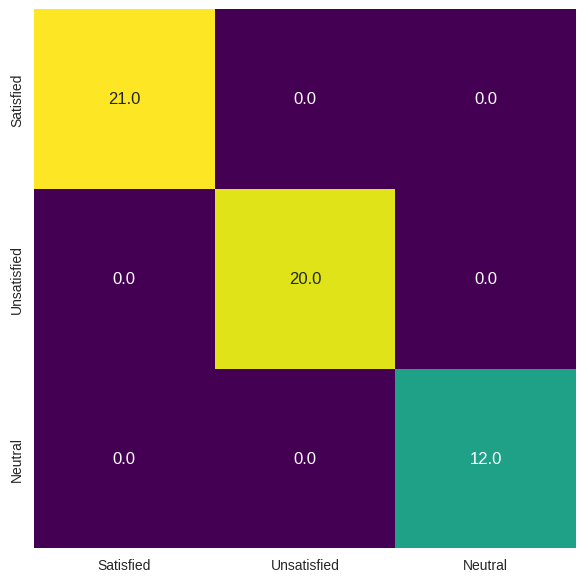

In [336]:
# Convert predictions and Satisfaction Level_indexs to RDD for MulticlassMetrics
prediction_and_Satisfaction = predictions.select("prediction", "Satisfaction Level_index").rdd.map(lambda row: (float(row["prediction"]), float(row["Satisfaction Level_index"])))

# Instantiate the MulticlassMetrics
metrics = MulticlassMetrics(prediction_and_Satisfaction)

# Get the confusion matrix
confusion_matrix = metrics.confusionMatrix().toArray()

# Plot the confusion matrix
# Unsatisfied: 1, Satisfied: 0, Neutral: 2
classes = ["Satisfied", "Unsatisfied", "Neutral"]
_ = plt.figure(figsize=(7, 7))
sns.heatmap(metrics.confusionMatrix().toArray(),
            cmap='viridis',
            annot=True,fmt='0',
            cbar=False, 
            xticklabels=classes, 
            yticklabels=classes)

Data seems to be a little bit perfect :D 